# Introduction
This notebook calculates pValues for the independant variables via bootstrapping.  Note that we are just looking for p-values. So train the rf on the entire dataset with 1 column scrambled, then get MEMs .  Do this many times.  Then train the entire rf with that column unscrambled, then get MEMs.  Plot these MEMs values.
Please be sure to run DataCleaning.ipynb first to prepare the data

This notebook based on Fastai V1 ML course

## Imports
Import libraries and write settings here.

In [1]:
from fastai.tabular import *
from fastai import *

# Data manipulation
import pandas as pd
import numpy as np

# Options for pandas
pd.options.display.max_columns = 60
pd.options.display.max_rows = 60

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from IPython import get_ipython
ipython = get_ipython()

# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload

%autoreload 2

# Visualizations
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected=True)

import cufflinks as cf
cf.go_offline(connected=True)
cf.set_config_file(theme='white')

# Load train/test
If either of the following fail then please be sure to run DataCleaning.ipynb first to prepare the data

In [2]:
# first column in each file is the dependent variable, the rest are independant
csv_files=['vote12gop','TrumpGEVote','TrumpPVote']

whichfle=2
fn = csv_files[whichfle]

trnfile = 'tmp/' + fn +'_train'
tstfile = 'tmp/' + fn +'_tst'
jsonfile = 'tmp/' + fn + '_catcont.json'

outdir = 'outBElectionResultsPVALSs'
filename='results.csv'
filename_all = 'results_complete.csv'
filename_model_params = "RF_model_params.sav"
os.makedirs(outdir, exist_ok=True)

In [3]:
trnfile

'tmp/TrumpPVote_train'

In [4]:
#get processed training and test data
trn = pd.read_feather(trnfile)
tst = pd.read_feather(tstfile)
# columns_dep_var= 'cc.vote16'

In [5]:
trn.head()

,index,cc.trumppvote,cc.age,cc.blackdum,cc.cc16_304,cc.cc16_305_2,cc.cc16_422c,cc.cc16_422d,cc.cc16_422e,cc.cc16_422f,cc.catholic,cc.evanprot,cc.ideo7,cc.inddum,cc.religiosity,cc.repdum,cc.sex,cc.whitedum,cc.emp.nojob,cc.faminc,cc.i.white.educhs,cc.immviewsum,cc.maxeduc.4yr,cc.union,crashpc,demo.popdense,job.uer,mort.ucd.despair.disc95.pdpy,rustpc
0,10476,0,0.965457,0,0.947973,0,0.517074,0.329550,0.818020,0.386066,0,0,0.451077,0,0.814553,0,0,1,0,1.264915,0,0.000000,0,1,0.355196,0.124574,0.811116,1.392480,0.417110
1,21132,0,1.201895,0,0.631982,1,0.517074,0.659101,1.227029,0.772133,0,0,0.225539,0,0.362024,0,0,1,0,1.686553,0,0.425285,0,1,0.933311,0.356074,0.913419,0.910270,0.600250
2,7689,1,1.241301,0,1.579954,0,1.551223,1.647751,1.636039,1.930331,1,0,1.353232,0,1.538600,1,0,1,0,0.281092,0,1.701138,0,0,0.543310,0.044815,1.070528,0.781661,0.000000
3,19541,0,0.729018,1,1.579954,0,0.517074,0.329550,0.409010,0.386066,0,0,1.578771,0,0.814553,0,1,0,0,0.562184,0,0.425285,0,0,0.746677,0.153367,1.002935,1.010251,0.869757
4,10267,0,1.103379,0,0.947973,0,0.517074,0.659101,0.818020,1.930331,1,0,1.578771,0,0.543035,1,1,1,0,0.843277,1,1.701138,0,0,2.122966,0.000300,0.281333,0.499205,0.546736


In [6]:
trn.drop('index',axis=1,inplace=True);
tst.drop('index',axis=1,inplace=True);

## Get continuous and categorical variables, convert dependant variable to int64

In [7]:
#get continuous and categorical variables
with open(jsonfile) as f:
    data1 = json.load(f)
    res_cont = data1[0]
    res_cat = data1[1] 
   
# res_cont
# res_cat

In [8]:
columns_dep_var = trn.columns[0]
columns_dep_var

'cc.trumppvote'

In [9]:
#remove the dependant variable
res_cont = [x for x in res_cont if x not in columns_dep_var]
res_cat = [x for x in res_cat if x not in columns_dep_var]

In [10]:
trn.head()

,cc.trumppvote,cc.age,cc.blackdum,cc.cc16_304,cc.cc16_305_2,cc.cc16_422c,cc.cc16_422d,cc.cc16_422e,cc.cc16_422f,cc.catholic,cc.evanprot,cc.ideo7,cc.inddum,cc.religiosity,cc.repdum,cc.sex,cc.whitedum,cc.emp.nojob,cc.faminc,cc.i.white.educhs,cc.immviewsum,cc.maxeduc.4yr,cc.union,crashpc,demo.popdense,job.uer,mort.ucd.despair.disc95.pdpy,rustpc
0,0,0.965457,0,0.947973,0,0.517074,0.329550,0.818020,0.386066,0,0,0.451077,0,0.814553,0,0,1,0,1.264915,0,0.000000,0,1,0.355196,0.124574,0.811116,1.392480,0.417110
1,0,1.201895,0,0.631982,1,0.517074,0.659101,1.227029,0.772133,0,0,0.225539,0,0.362024,0,0,1,0,1.686553,0,0.425285,0,1,0.933311,0.356074,0.913419,0.910270,0.600250
2,1,1.241301,0,1.579954,0,1.551223,1.647751,1.636039,1.930331,1,0,1.353232,0,1.538600,1,0,1,0,0.281092,0,1.701138,0,0,0.543310,0.044815,1.070528,0.781661,0.000000
3,0,0.729018,1,1.579954,0,0.517074,0.329550,0.409010,0.386066,0,0,1.578771,0,0.814553,0,1,0,0,0.562184,0,0.425285,0,0,0.746677,0.153367,1.002935,1.010251,0.869757
4,0,1.103379,0,0.947973,0,0.517074,0.659101,0.818020,1.930331,1,0,1.578771,0,0.543035,1,1,1,0,0.843277,1,1.701138,0,0,2.122966,0.000300,0.281333,0.499205,0.546736


In [11]:
#convert trumpgevote to long (otherwise fit fails)
trn[columns_dep_var] = trn[columns_dep_var].astype('int64');
tst[columns_dep_var] = tst[columns_dep_var].astype('int64');

print(str(len(trn)))
print(str(len(tst)))

24716
2747


In [12]:
#split out trn_y and tst_y
#this is the dep_var, converted to an int
trn_y = trn[columns_dep_var].copy()
tst_y = tst[columns_dep_var].copy()
trn_y.astype('int64');
trn_y.astype('int64');

trn.drop(columns_dep_var,axis=1,inplace=True);
tst.drop(columns_dep_var,axis=1,inplace=True);

## Lets see what features are corelated with each other

In [13]:
# from rfpimp import plot_corr_heatmap
# viz = plot_corr_heatmap(trn, figsize=(50,30))
# viz.view()

## Categorify and Fill Missing

In [14]:
#from docs https://docs.fast.ai/tabular.transform.html
# tfm = Categorify(cat_names=res_cat, cont_names=res_cont)
# tfm(trn)
# tfm(tst)
# #just checking to see if it works on any old variable
# trn[res_cat[0]].cat.categories
# tst[res_cat[0]].cat.categories

In [15]:
tfm1 = FillMissing(cat_names=res_cat, cont_names=res_cont, add_col=False)
tfm1(trn)
tfm1(tst)

## Clean up any missing columns that result from unfortunate test selection

In [16]:
columns_dep_var

'cc.trumppvote'

In [17]:
#You cannot have any Nan (missing data) fields or random forest will not work.
print(f"Total trn columns = {len(trn.columns)}, total tst columns = {len(tst.columns)}") 
print(f"Total trn columns with Nans= {len(trn.columns[trn.isnull().any()])}") #add ~ to get columns with no missing values
print(f"Total tst columns with Nans= {len(tst.columns[tst.isnull().any()])}") #add ~ to get columns with no missing values

Total trn columns = 27, total tst columns = 27
Total trn columns with Nans= 0
Total tst columns with Nans= 0


In [18]:
#hmmm if either has 1 more column than train then see what it is
set(tst.columns)-set(trn.columns)
set(trn.columns)-set(tst.columns)

#missing one of the _na columns.  This is added, and set to 1, when a variable has an NaN value to mark
#columns that have NaNs

#find the index of the column in trn
# idx=trn.columns.tolist().index('cc.catholic_na')
# idx
# type(trn.columns)

# tst.insert(loc=idx, column='cc.catholic_na', value=False)

set()

set()

In [19]:
trn.head()

,cc.age,cc.blackdum,cc.cc16_304,cc.cc16_305_2,cc.cc16_422c,cc.cc16_422d,cc.cc16_422e,cc.cc16_422f,cc.catholic,cc.evanprot,cc.ideo7,cc.inddum,cc.religiosity,cc.repdum,cc.sex,cc.whitedum,cc.emp.nojob,cc.faminc,cc.i.white.educhs,cc.immviewsum,cc.maxeduc.4yr,cc.union,crashpc,demo.popdense,job.uer,mort.ucd.despair.disc95.pdpy,rustpc
0,0.965457,0,0.947973,0,0.517074,0.329550,0.818020,0.386066,0,0,0.451077,0,0.814553,0,0,1,0,1.264915,0,0.000000,0,1,0.355196,0.124574,0.811116,1.392480,0.417110
1,1.201895,0,0.631982,1,0.517074,0.659101,1.227029,0.772133,0,0,0.225539,0,0.362024,0,0,1,0,1.686553,0,0.425285,0,1,0.933311,0.356074,0.913419,0.910270,0.600250
2,1.241301,0,1.579954,0,1.551223,1.647751,1.636039,1.930331,1,0,1.353232,0,1.538600,1,0,1,0,0.281092,0,1.701138,0,0,0.543310,0.044815,1.070528,0.781661,0.000000
3,0.729018,1,1.579954,0,0.517074,0.329550,0.409010,0.386066,0,0,1.578771,0,0.814553,0,1,0,0,0.562184,0,0.425285,0,0,0.746677,0.153367,1.002935,1.010251,0.869757
4,1.103379,0,0.947973,0,0.517074,0.659101,0.818020,1.930331,1,0,1.578771,0,0.543035,1,1,1,0,0.843277,1,1.701138,0,0,2.122966,0.000300,0.281333,0.499205,0.546736


## Generate MEM row 
RUN ON WHOLE DATASET OR JUST THE TestSET?  I'm thinking the whole dataset.  
The model has some idea of how voters will vote based on the input features, lets use that knowledge
to see what happens when we start changing variables

In [20]:
all = trn.copy()
all_y = trn_y.copy()
len(all)
all.head()

24716

,cc.age,cc.blackdum,cc.cc16_304,cc.cc16_305_2,cc.cc16_422c,cc.cc16_422d,cc.cc16_422e,cc.cc16_422f,cc.catholic,cc.evanprot,cc.ideo7,cc.inddum,cc.religiosity,cc.repdum,cc.sex,cc.whitedum,cc.emp.nojob,cc.faminc,cc.i.white.educhs,cc.immviewsum,cc.maxeduc.4yr,cc.union,crashpc,demo.popdense,job.uer,mort.ucd.despair.disc95.pdpy,rustpc
0,0.965457,0,0.947973,0,0.517074,0.329550,0.818020,0.386066,0,0,0.451077,0,0.814553,0,0,1,0,1.264915,0,0.000000,0,1,0.355196,0.124574,0.811116,1.392480,0.417110
1,1.201895,0,0.631982,1,0.517074,0.659101,1.227029,0.772133,0,0,0.225539,0,0.362024,0,0,1,0,1.686553,0,0.425285,0,1,0.933311,0.356074,0.913419,0.910270,0.600250
2,1.241301,0,1.579954,0,1.551223,1.647751,1.636039,1.930331,1,0,1.353232,0,1.538600,1,0,1,0,0.281092,0,1.701138,0,0,0.543310,0.044815,1.070528,0.781661,0.000000
3,0.729018,1,1.579954,0,0.517074,0.329550,0.409010,0.386066,0,0,1.578771,0,0.814553,0,1,0,0,0.562184,0,0.425285,0,0,0.746677,0.153367,1.002935,1.010251,0.869757
4,1.103379,0,0.947973,0,0.517074,0.659101,0.818020,1.930331,1,0,1.578771,0,0.543035,1,1,1,0,0.843277,1,1.701138,0,0,2.122966,0.000300,0.281333,0.499205,0.546736


# Generate pValue predictions

In [21]:
#this directory contains symlink created at command line like this
# ln -s ../Marginal_Effects_at_Means ./Marginal_Effects_at_Means
#it allows this directory to find Marginal_Effects_at_Means, a directory 1 above this one
#this dir contains a file called mem.py which contains MEMs
from p_value_calculation.pvals import pValue,pValInfo

In [22]:
#run the test cases
# from p_value_calculation.test_pvals import Test_pvals
# tst = Test_pvals()
# tst.setUp()
# tst.test_get_pval_bin()

In [23]:
# #get something small to train on
# NUMBERSAMPS = 1000
# trn_sm = trn[:NUMBERSAMPS]
# trn_sm_y= trn_y[:NUMBERSAMPS]
# tst_sm = tst[:NUMBERSAMPS]
# tst_sm_y = tst[:NUMBERSAMPS]
# columns=['cc.raceviewsum']

# len(trn_sm),len(trn_sm_y),len(tst_sm) 
# columns = ['cc.raceviewsum', 'cc.CC16_307']

In [24]:
columns=all.columns
columns
# columns1=['cc.emp.nojob']

Index(['cc.age', 'cc.blackdum', 'cc.cc16_304', 'cc.cc16_305_2', 'cc.cc16_422c',
       'cc.cc16_422d', 'cc.cc16_422e', 'cc.cc16_422f', 'cc.catholic',
       'cc.evanprot', 'cc.ideo7', 'cc.inddum', 'cc.religiosity', 'cc.repdum',
       'cc.sex', 'cc.whitedum', 'cc.emp.nojob', 'cc.faminc',
       'cc.i.white.educhs', 'cc.immviewsum', 'cc.maxeduc.4yr', 'cc.union',
       'crashpc', 'demo.popdense', 'job.uer', 'mort.ucd.despair.disc95.pdpy',
       'rustpc'],
      dtype='object')

In [25]:
NUMBERITERATIONS=500
pv=pValue(trn, trn_y,columns,numb_iter=NUMBERITERATIONS, verbose=True)
res = pv.get_all_pvals()

Column cc.age

..................................................
Column cc.blackdum

..................................................
Column cc.cc16_304

..................................................
Column cc.cc16_305_2

..................................................
Column cc.cc16_422c

..................................................
Column cc.cc16_422d

..................................................
Column cc.cc16_422e

..................................................
Column cc.cc16_422f

.........................................
Column cc.catholic

..................................................
Column cc.evanprot

..................................................
Column cc.ideo7

..................................................
Column cc.inddum

..........................................
Column cc.religiosity

..................................................
Column cc.repdum

..................................................
Column cc.sex

...........

# Save, print and plot 

In [26]:
outfile ='PVAL_results_'+fn+'.csv'
outfile

'PVAL_results_TrumpPVote.csv'

In [27]:
# save this info to disk
pickle.dump(res, open(outdir+"/"+outfile, 'wb'))

In [28]:
# load the model from disk
res = pickle.load(open(outdir+"/"+outfile, 'rb'))

In [29]:
#used to convert old pValInfo objects to new ones with comparisons (lt, eq) and self.pVal
# res2=[]
# for c in res1:
#     a=pValInfo(c.col)
#     a.correct_pred = c.correct_pred[:]
#     a.permuted_preds = c.permuted_preds[:]
#     res2.append(a)

In [30]:
res=sorted(res)

#print values
for item in res:
    print(f'Column {item.col}, p-value={item.get_pval()}')

Column cc.age, p-value=0.0
Column cc.blackdum, p-value=0.0
Column cc.cc16_304, p-value=0.0
Column cc.cc16_422c, p-value=0.0
Column cc.cc16_422d, p-value=0.0
Column cc.ideo7, p-value=0.0
Column cc.inddum, p-value=0.0
Column cc.repdum, p-value=0.0
Column cc.whitedum, p-value=0.0
Column cc.immviewsum, p-value=0.0
Column job.uer, p-value=0.0020000000000000018
Column rustpc, p-value=0.006
Column cc.maxeduc.4yr, p-value=0.018
Column cc.cc16_422f, p-value=0.028
Column cc.cc16_305_2, p-value=0.032
Column cc.i.white.educhs, p-value=0.06
Column cc.religiosity, p-value=0.08599999999999997
Column cc.union, p-value=0.10599999999999998
Column mort.ucd.despair.disc95.pdpy, p-value=0.138
Column crashpc, p-value=0.176
Column cc.emp.nojob, p-value=0.22
Column cc.catholic, p-value=0.242
Column cc.evanprot, p-value=0.28200000000000003
Column demo.popdense, p-value=0.302
Column cc.sex, p-value=0.354
Column cc.cc16_422e, p-value=0.392
Column cc.faminc, p-value=0.414


In [31]:
filenamecsv = 'pvals'+fn+ '.csv'

In [32]:
with open(outdir+"/"+filenamecsv, 'w' ) as f:
    for item in res:
        _=f.write(f'{item.col},{item.get_pval()}\n');

In [33]:
def draw_histograms(res, variables, n_rows, n_cols):
    fig, ax=plt.subplots(nrows=n_rows,ncols=n_cols, figsize=(15,30) )
    fig.subplots_adjust(hspace=.5, wspace=.1)
    for i in range(n_rows):
        for j in range(n_cols):
            try:
                tmp = res[((i)*n_cols)+j]
            except:
                pass   
            ax[i,j].set_title(f'{tmp.col}, pval={tmp.get_pval()}')
            ax[i,j].hist(tmp.permuted_preds,bins= 50,ec='red', label='permuted')
            ax[i,j].axvline(tmp.correct_pred, color='k', linestyle='dashed', linewidth=1, label='not-permuted')
    plt.show()

--- line is not-permuted calc, others are permuted calcs


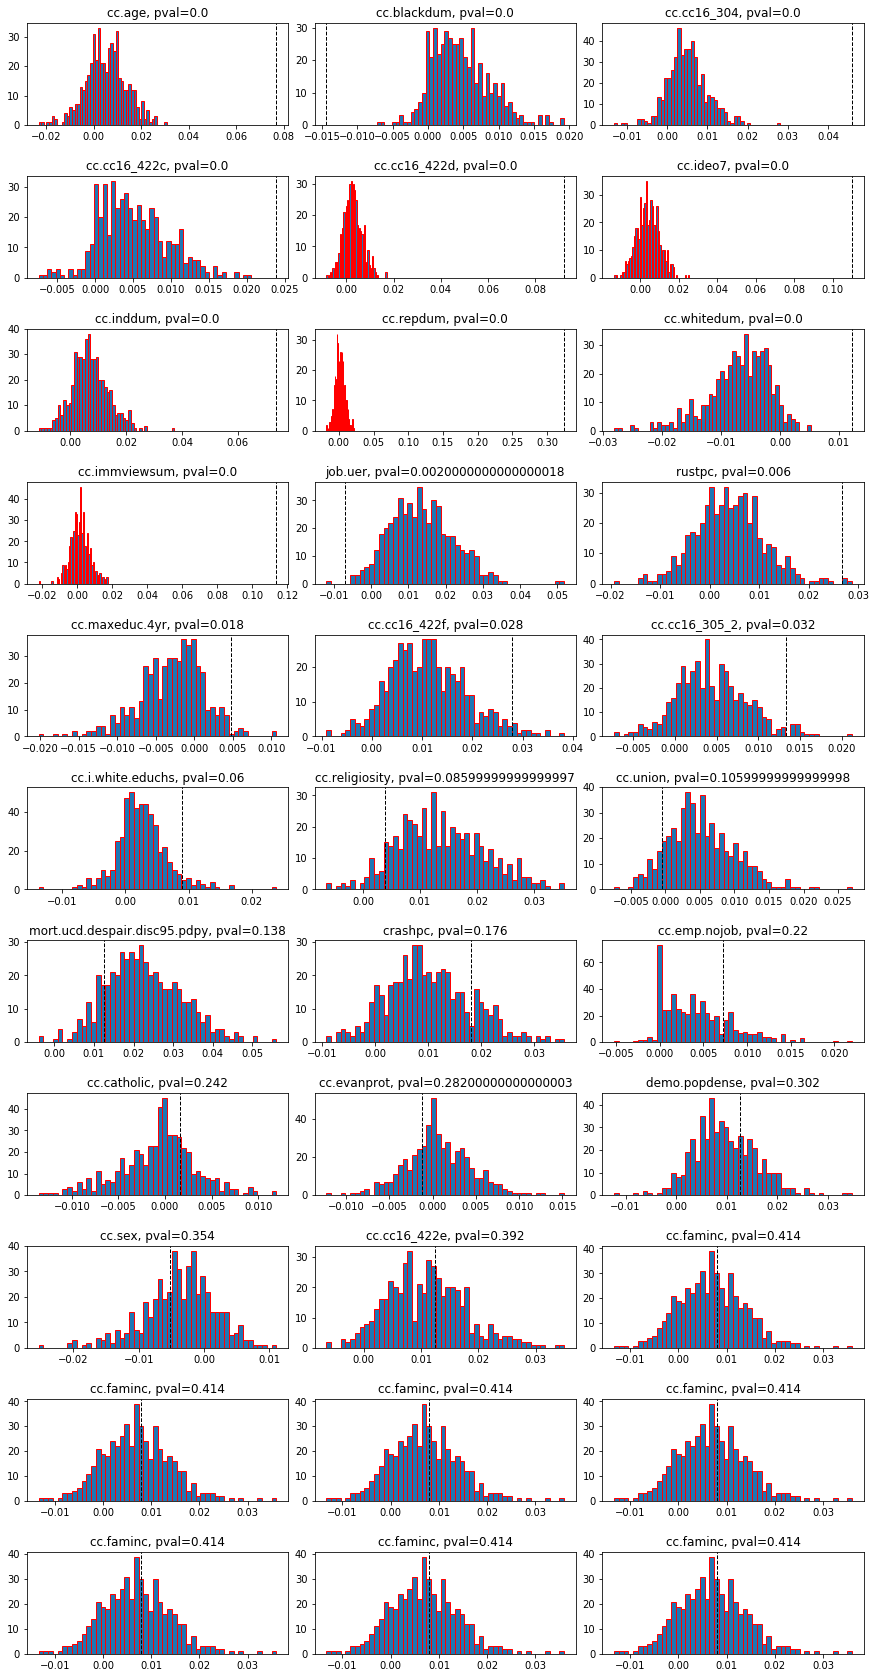

In [34]:
print ("--- line is not-permuted calc, others are permuted calcs")
draw_histograms(res, columns, 11,3)